In [ ]:
from fastai import *
from fastai.text import * 
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
random_seed(42, True)

In [ ]:
# bring en files (all then filter)
!wget https://raw.githubusercontent.com/abedkhooli/ds2/master/ulmfit2/prepare_xnli.sh 

--2021-06-13 10:15:07--  https://raw.githubusercontent.com/abedkhooli/ds2/master/ulmfit2/prepare_xnli.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772 [text/plain]
Saving to: ‘prepare_xnli.sh’

prepare_xnli.sh     100%[===================>]     772  --.-KB/s    in 0s      

2021-06-13 10:15:07 (55.0 MB/s) - ‘prepare_xnli.sh’ saved [772/772]



In [ ]:
filename_dev = 'xnli.dev.tsv'
filename_test = 'xnli.test.tsv'
df_dev = pd.read_csv(filename_dev, delimiter='\t', quoting=csv.QUOTE_NONE)
df_test = pd.read_csv(filename_test, delimiter='\t', quoting=csv.QUOTE_NONE)
len(df_dev), len(df_test)

(37350, 75150)

In [ ]:
df_dev_tr= df_dev[df_dev['language']=='tr']
df_test_tr= df_test[df_test['language']=='tr']
len(df_dev_tr), len(df_test_tr)
# Each language has 2490 dev samples and 5010 test samples (from readme).

(2490, 5010)

In [ ]:
df_dev_tr = df_dev_tr[['gold_label','sentence1_tokenized', 'sentence2_tokenized']]
df_test_tr = df_test_tr[['gold_label','sentence1_tokenized', 'sentence2_tokenized']]
df_dev_tr['is_valid'] = False
df_test_tr['is_valid'] = True
df_test_tr.head()

,gold_label,sentence1_tokenized,sentence2_tokenized,is_valid
55110,contradiction,"Pekala , bunu hiç düşünmemiştim ancak kafam ço...",Onunla bir daha konuşmadım .,True
55111,entailment,"Pekala , bunu hiç düşünmemiştim ancak kafam ço...",O kadar çok üzgündüm ki onunla tekrar konuşmay...,True
55112,neutral,"Pekala , bunu hiç düşünmemiştim ancak kafam ço...",Harika bir konuşma yaptık .,True
55113,neutral,"Ve bunun bir ayrıcalık olduğunu sanıyordum , v...",O gün tarladaki tek kişi olmadığımın farkında ...,True
55114,entailment,"Ve bunun bir ayrıcalık olduğunu sanıyordum , v...",AFFC Hava Kuvvetleri Kariyer alanında o numara...,True


In [ ]:
df_all = pd.concat([df_dev_tr,df_test_tr])
df_all['gold_label'].value_counts()

neutral          2500
entailment       2500
contradiction    2500
Name: gold_label, dtype: int64

In [ ]:
# create a data folder and copy train and test data into it 
Path('data/xnli_tr/').mkdir(parents=True, exist_ok=True)
df_all.to_csv('data/xnli_tr/xnli_text.csv', index=False)

In [ ]:
processor = [TokenizeProcessor(mark_fields=True), NumericalizeProcessor(max_vocab=60000)]

In [ ]:
path = Path('data/xnli_tr/')
path.ls()

[PosixPath('data/xnli_tr/xnli_text.csv')]

In [ ]:
data_lm = (TextList.from_csv(path, 'xnli_text.csv', cols=['sentence1_tokenized', 'sentence2_tokenized'],processor = processor)
                   .random_split_by_pct()
                   .label_for_lm()
                   .databunch())
data_lm.save()

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.show_batch(10)

idx,text
0,"xxunk yeri bulmaya çalışırken xxunk . xxbos xxfld 1 xxmaj ne için gittiğimi falan bilmiyordum , xxmaj washington ' da belirtilen bir yere rapor vermem gerekiyordu . xxfld 2 xxmaj washington ' a xxunk ne yapmam gerektiğini tam olarak biliyordum . xxbos xxfld 1 xxmaj ne için gittiğimi falan bilmiyordum , xxmaj washington ' da belirtilen bir yere rapor vermem gerekiyordu . xxfld 2 xxmaj ne xxunk çok emin değildim"
1,sundurmanın önünden aşağı doğru yürüdü ve oraya doğru yürüyordu ve o da orada durdu . xxfld 2 xxmaj büyükanne xxunk xxunk . xxbos xxfld 1 xxmaj büyükanne kalktı ve sundurmanın önünden aşağı doğru yürüdü ve oraya doğru yürüyordu ve o da orada durdu . xxfld 2 xxmaj büyükanne xxunk 100 adım yürüdü . xxbos xxfld 1 xxmaj büyükanne kalktı ve sundurmanın önünden aşağı doğru yürüdü ve oraya doğru yürüyordu ve
2,"şeyin etek ve etek ve bluz veya takım elbise veya elbise olduğunu biliyorsunuz , bu yüzden evde çalışmama rağmen güzel çünkü pantolon giyebiliyorum xxfld 2 xxmaj evde çalışırken hala elbise xxunk çünkü daha süslü hissediyorum . xxbos xxfld 1 evet , bilmem gereken bir yere sahip olmakla ilgili bir şey var xxfld 2 xxmaj yaşayacak bir yere sahip olma hayali gerçek oldu . xxbos xxfld 1 evet , bilmem gereken"
3,"anlatacak ne yapıyoruz ? xxbos xxfld 1 xxmaj tabii ki onlar , onlar için kesinlikle xxunk bildiğiniz yerlerde xxunk , ama geniş geniş xxunk geleceğini xxunk . xxfld 2 xxmaj bazı insanlar yaşlı akrabalarını önemsemiyor çünkü xxunk çok sayıda merdiven var . xxbos xxfld 1 xxmaj tabii ki onlar , onlar için kesinlikle xxunk bildiğiniz yerlerde xxunk , ama geniş geniş xxunk geleceğini xxunk . xxfld 2 xxmaj bazı insanlar"
4,"ulaşır ve tablonun sınırlarına kadar uzanır . xxfld 2 xxmaj kum her zaman düz ve xxunk . xxbos xxfld 1 xxmaj kum yığılırken , sonuç olarak kum için dinlenme açısına ulaşır ve tablonun sınırlarına kadar uzanır . xxfld 2 xxmaj kum bir buldozer yardımıyla xxunk . xxbos xxfld 1 xxmaj biyosfer , sürekli xxunk bitişik olana doğru xxunk , hatta , az ya da çok ısrarla patladı . xxfld 2"
5,"kondisyonun doruklarına doğru çekmeye zorlayabilir . xxfld 2 xxmaj daha yüksek fitness seviyelerinde , xxunk xxunk hayatta kalma olasılığı daha yüksektir . xxbos xxfld 1 xxmaj fitness manzarasında , görüntü , mutasyon , rekombinasyon ve seçim , gelişen nüfusları yüksek kondisyonun doruklarına doğru çekmeye zorlayabilir . xxfld 2 xxmaj xxunk nüfusları daha yüksek xxunk xxunk çekmek için birçok etmen aynı anda xxunk . xxbos xxfld 1 xxmaj fitness manzarasında ,"
6,xxunk . xxfld 2 xxmaj onların xxunk xxunk xxunk geldi . xxbos xxfld 1 xxmaj hangisi daha iyi bir yol ? talep etti . xxfld 2 xxmaj en iyi yolu xxunk bildiği için herhangi bir soru sormadı . xxbos xxfld 1 xxmaj hangisi daha iyi bir yol ? talep etti . xxfld 2 xxmaj daha iyi bir yol olup olmadığını bilmek istiyordu . xxbos xxfld 1 xxmaj hangisi daha iyi
7,"gelmesi ile sürekli olarak artan sırasında belindeki parmağını erkeklere doğru aşağılayıcı bir biçimde salladı . xxfld 2 xxmaj herkes üst xxunk xxunk yol xxunk xxunk xxunk xxunk . xxbos xxfld 1 xxmaj bilakis bu onun heyecanını artırmıştı . xxfld 2 o heyecanını azalttı . xxbos xxfld 1 xxmaj bilakis bu onun heyecanını artırmıştı . xxfld 2 xxmaj bu , onu hiç olmadığı kadar heyecanlı biri yaptı . xxbos xxfld 1"
8,"dır . xxfld 2 xxmaj brahma xxmaj hindu xxunk bir parçasıdır . xxbos xxfld 1 xxmaj xxunk xxunk aldı , ancak silahlı mücadele xxunk devam etti ve ondan sonra da uzun süre devam eden acı . xxfld 2 xxmaj savaş sadece bir günde sona xxunk . xxbos xxfld 1 xxmaj xxunk xxmaj xxunk ' ın altındaki birkaç yüz xxunk xxunk , xxmaj atinalılar ' ın xxmaj xxunk xxunk tahliye xxunk"
9,xxfld 1 o gece en büyük kalabalığı çekmek amacıyla özel kuponlar gün boyu plajlarda yoğun şekilde dağıtılmakta . xxfld 2 xxmaj uzun vadeli müşteri umuduyla xxunk kuponlar xxunk . xxbos xxfld 1 o gece en büyük kalabalığı çekmek amacıyla özel kuponlar gün boyu plajlarda yoğun şekilde dağıtılmakta . xxfld 2 xxmaj kuponlar xxunk xxunk çekmek

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


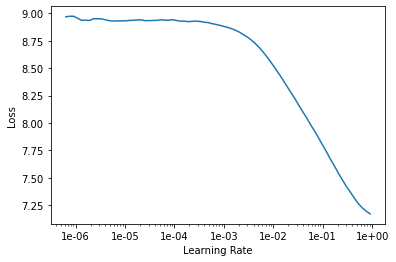

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)
#learn = language_model_learner(data_lm, pretrained_model=AWD_LSTM, drop_mult=0.1)
learn.lr_find()
learn.recorder.plot(skip_end=12)

In [ ]:
learn.fit_one_cycle(1, 4e-2) # was 10 

epoch,train_loss,valid_loss,accuracy,time
0,5.336092,3.936434,0.406771,07:41


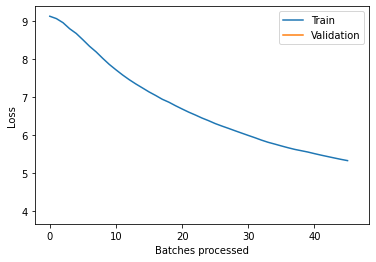

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# first amount of words (here 10), the next 10 target words (actual) and the ones predicted.
learn.show_results(max_len = 10)

text,target,pred
"xxbos xxfld 1 xxmaj onunla ilgili xxunk , bütün gece","çok huzurlu olan , xxunk erkeklerin çılgınca aktif xxunk vardı","xxunk xxunk xxunk , xxunk xxunk xxunk xxunk bir xxunk"
"xxunk , sosyal ve politik adaletin xxunk inşa edilmiştir .",xxbos xxfld 1 yaklaşık yüzde xxunk sülfür bitümlü kömür xxunk,xxbos xxfld 1 xxmaj xxunk on ve . . .
tüm bilgiyi xxunk için hayal kırıklığı yaşadığımı ona açıklamaya çalıştım,. xxfld 2 xxmaj ona başka bir şey duymak xxunk,. xxfld 2 xxmaj xxunk xxunk xxfld xxunk xxunk .
yok bu yüzden söylemek pek kolay değil xxfld 2 xxmaj,yedi çocuğum var yani xxunk xxunk biliyorum ! xxbos xxfld,xxunk xxfld xxfld . xxunk xxunk . . xxbos xxfld
1 xxmaj sant xxmaj xxunk ' nun xxmaj romanesk xxunk,"xxunk , xxmaj barselona ' nın xxunk ve xxmaj gotik",. . xxunk xxunk ' nın xxunk xxunk xxunk xxunk


In [ ]:
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

In [ ]:
data_clas = (TextList.from_csv(path, 'xnli_text.csv', cols=['sentence1_tokenized', 'sentence2_tokenized'],processor = processor, vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='gold_label')
                   .databunch(bs=42))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxfld 1 6 : 45 ve 7 : 40 arası , xxmaj atta ve xxmaj omari , xxmaj xxunk al xxmaj xxunk , xxmaj wail al xxmaj shehri ve xxmaj xxunk al xxmaj shehri ile birlikte , xxunk - in yaptı ve xxmaj los xxmaj angeles ' a giden xxmaj american xxmaj xxunk 11 xxunk xxunk bindi . xxfld 2 xxmaj atta ve xxmaj omari xxunk yanı xxunk ve",neutral
"xxbos xxfld 1 6 : 45 ve 7 : 40 arası , xxmaj atta ve xxmaj omari , xxmaj xxunk al xxmaj xxunk , xxmaj wail al xxmaj shehri ve xxmaj xxunk al xxmaj shehri ile birlikte , xxunk - in yaptı ve xxmaj los xxmaj angeles ' a giden xxmaj american xxmaj xxunk 11 xxunk xxunk bindi . xxfld 2 xxmaj xxunk gitmeye xxunk ama xxmaj wail al xxmaj",contradiction
"xxbos xxfld 1 6 : 45 ve 7 : 40 arası , xxmaj atta ve xxmaj omari , xxmaj xxunk al xxmaj xxunk , xxmaj wail al xxmaj shehri ve xxmaj xxunk al xxmaj shehri ile birlikte , xxunk - in yaptı ve xxmaj los xxmaj angeles ' a giden xxmaj american xxmaj xxunk 11 xxunk xxunk bindi . xxfld 2 xxmaj los xxmaj angeles ' a saat xxunk :",entailment
"xxbos xxfld 1 xxmaj böylece , ortalama olarak xxmaj webster ' s xxmaj xxunk xxmaj new xxmaj xxunk ve xxmaj xxunk xxmaj house xxmaj webster xxmaj xxunk , xxmaj amerikan xxmaj xxunk ve xxmaj webster ' ın xxmaj yeni xxmaj dünya ' sından en az yüzde on beş daha fazla bilgi içeriyor . xxfld 2 xxmaj webster ' s xxmaj college ' ta diğer xxunk çok daha fazla eksik bilgi",contradiction
"xxbos xxfld 1 xxmaj böylece , ortalama olarak xxmaj webster ' s xxmaj xxunk xxmaj new xxmaj xxunk ve xxmaj xxunk xxmaj house xxmaj webster xxmaj xxunk , xxmaj amerikan xxmaj xxunk ve xxmaj webster ' ın xxmaj yeni xxmaj dünya ' sından en az yüzde on beş daha fazla bilgi içeriyor . xxfld 2 xxmaj webster ' s xxmaj college ' ta xxmaj yeni xxmaj dünyadan daha fazla bilgi",entailment


In [ ]:
learn_clas = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
# learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

learn_clas.load_encoder('mini_train_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2490 items)
x: TextList
xxbos xxfld 1 xxmaj ve xxmaj anne , xxunk dedi . xxfld 2 xxmaj okul servisi onu xxunk xxunk xxunk xxunk .,xxbos xxfld 1 xxmaj ve xxmaj anne , xxunk dedi . xxfld 2 xxmaj bir kelime söylemedi .,xxbos xxfld 1 xxmaj ve xxmaj anne , xxunk dedi . xxfld 2 xxmaj annesine eve gittiğini söyledi .,xxbos xxfld 1 xxmaj ne için gittiğimi falan bilmiyordum , xxmaj washington ' da belirtilen bir yere rapor vermem gerekiyordu . xxfld 2 xxmaj washington ' a hiç gitmedim , bu yüzden oraya xxunk yeri bulmaya çalışırken xxunk .,xxbos xxfld 1 xxmaj ne için gittiğimi falan bilmiyordum , xxmaj washington ' da belirtilen bir yere rapor vermem gerekiyordu . xxfld 2 xxmaj washington ' a xxunk ne yapmam gerektiğini tam olarak biliyordum .
y: CategoryList
neutral,contradiction,entailment,neutral,contradiction
Path: data/xnli_tr;

Valid: LabelList (5010 items)
x: TextList
xxbos xxfld 1 xxmaj pekala , bunu hiç düşünmemiştim ancak kafam çok

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


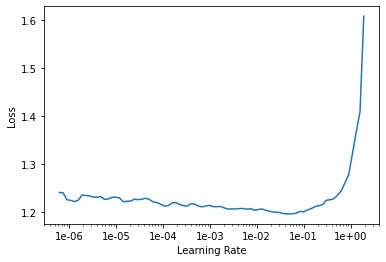

In [ ]:
learn_clas.lr_find() # start_lr=1e-15, end_lr=1e2
learn_clas.recorder.plot() # skip_end=4

In [ ]:
learn_clas.fit_one_cycle(4, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.188049,1.125657,0.364870,04:00
1,1.132703,1.097534,0.359082,03:55
2,1.111475,1.090345,0.384032,03:46
3,1.095338,1.088027,0.390419,03:51


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn_clas.show_results()

text,target,prediction
"xxbos xxfld 1 1972 ' de xxmaj phillip xxmaj morris , xxmaj inc . ' in xxmaj miller xxmaj brewing xxmaj co. şirketi , xxmaj meister xxmaj brau xxmaj inc. şirketinin satınalmasında xxmaj lite bira etiketini satın aldı . xxfld 2 xxmaj phillip xxmaj morris , xxmaj inc . ' in xxunk xxmaj miller xxmaj brewing xxmaj co . xxmaj meister xxmaj brau xxmaj inc . , xxunk tümünü satın",contradiction,entailment
"xxbos xxfld 1 1972 ' de xxmaj phillip xxmaj morris , xxmaj inc . ' in xxmaj miller xxmaj brewing xxmaj co. şirketi , xxmaj meister xxmaj brau xxmaj inc. şirketinin satınalmasında xxmaj lite bira etiketini satın aldı . xxfld 2 xxmaj phillip xxmaj morris , xxmaj inc . ' in xxmaj miller xxmaj brewing xxmaj co . , 1972 ' de xxmaj meister xxmaj brau xxmaj inc . '",entailment,entailment
"xxbos xxfld 1 xxmaj daha fazla xxmaj anti - xxmaj defamation xxmaj league ' in araştırması , xxmaj amerika ' nın sert çekirdekli anti - semitlerinde , 1964 ' teki yüzde 29 ' dan 1992 ' de yüzde 20 ' ye , şu an yüzde 12 ' ye kadar devam eden bir düşüşü açıklıyor . xxfld 2 xxmaj xxunk ve xxmaj xxunk xxmaj mücadele xxmaj birliği anketi xxmaj amerika '",contradiction,contradiction
"xxbos xxfld 1 xxmaj deborah xxmaj cameron ve xxmaj deborah xxmaj hills ( ' xxmaj radyo konuşması ' : radyo programlarına xxunk xxunk xxunk ve xxunk arasındaki ilişkileri xxunk ) xxmaj londra ' daki konuşma ve tartışma istasyonu olan ve ilgiyle xxunk xxup lbc xxmaj radyo ' nun xxunk xxunk . xxfld 2 xxmaj deborah xxmaj cameron ve xxmaj deborah xxmaj hills , xxup lbc xxmaj radyo ' da olanlarla",neutral,contradiction
"xxbos xxfld 1 xxmaj daha fazla xxmaj anti - xxmaj defamation xxmaj league ' in araştırması , xxmaj amerika ' nın sert çekirdekli anti - semitlerinde , 1964 ' teki yüzde 29 ' dan 1992 ' de yüzde 20 ' ye , şu an yüzde 12 ' ye kadar devam eden bir düşüşü açıklıyor . xxfld 2 xxmaj xxunk xxmaj karşıtı xxmaj derneği ' nin anketi xxmaj amerika ' da",entailment,entailment


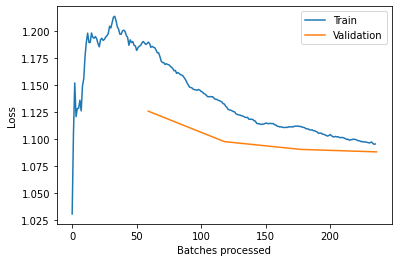

In [ ]:
learn_clas.recorder.plot_losses()

In [ ]:
import os 
learn_clas.save(os.getcwd()+'mini_train_clas')

In [ ]:
#train for 10 epochs
learn_clas.fit_one_cycle(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.084084,1.092469,0.380040,03:56
1,1.092571,1.087942,0.383433,03:53
2,1.102286,1.089049,0.373852,03:46
3,1.097809,1.103657,0.375050,03:51
4,1.093141,1.092478,0.379242,03:53
5,1.089430,1.085126,0.396607,03:52
6,1.087934,1.083125,0.395409,03:46
7,1.082444,1.081510,0.404192,03:52
8,1.079826,1.080719,0.408383,03:48
9,1.074489,1.081484,0.405589,03:53


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar